In [6]:
import numpy as np
import time
from collections import namedtuple
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import qiskit as q
import qiskit.tools.jupyter
from qiskit.pulse import pulse_lib as _  # only want to call pulse_lib as q.pulse.pulse_lib

In [3]:
q.IBMQ.load_account()

<AccountProvider for IBMQ(hub='ibm-q', group='open', project='main')>

In [4]:
import pulse_compiler_helper_fns

In [5]:
provider = q.IBMQ.get_provider(group='qiskit-terra', project='pulse-testing')
backend = provider.get_backend('alt_almaden')
system = q.pulse.PulseChannelSpec.from_backend(backend)
cmd_def = q.pulse.CmdDef.from_defaults(backend.defaults().cmd_def, backend.defaults().pulse_library)
measure = cmd_def.get('measure', qubits=backend.configuration().meas_map[0])

In [6]:
schedules = []
thetas = np.linspace(0, np.pi, 41)
for theta in thetas:
    for basis in ['X', 'Y', 'Z']:
        circuit = q.QuantumCircuit(1)
        circuit.rx(theta, 0)
        decomposed_circuit = circuit.decompose()
        pulse_compiler_helper_fns.update_basis_gates_and_cmd_def(decomposed_circuit, backend, system, cmd_def)
        transpiled_circuit = q.transpile(circuit, backend, optimization_level=1)
        schedule = q.schedule(transpiled_circuit, backend=backend, cmd_def=cmd_def)
        if basis == 'Y':  # apply H Sdag
            schedule |= cmd_def.get('u1', qubits=[0], P0=-np.pi/2) << schedule.duration
            schedule |= cmd_def.get('u2', qubits=[0], P0=0, P1=np.pi) << schedule.duration
        elif basis == 'X':  # apply H
            schedule |= cmd_def.get('u2', qubits=[0], P0=0, P1=np.pi) << schedule.duration
        schedule |= measure << schedule.duration
        schedules.append(schedule)

In [7]:
len(schedules)

123

In [8]:
shots = 2000
job = q.execute(schedules, backend=backend, shots=shots)
print(job.job_id())

5dcef6210a4553001192eddc


In [11]:
job.status()

<JobStatus.DONE: 'job has successfully run'>

In [12]:
backend.status()

BackendStatus(backend_name='alt_almaden', backend_version='1.2.4', operational=True, pending_jobs=0, status_msg='active')

In [13]:
result = job.result()

In [18]:
#from qiskit.ignis.mitigation import measurement
from qiskit.ignis.verification.tomography.data import marginal_counts

meas_fitter = measurement.fitters.CompleteMeasFitter(None, state_labels=['0', '1'])
prob_meas0_prep1 = 0.06
prob_meas1_prep0 = 0.03666
meas_fitter.cal_matrix = np.array([[1 - prob_meas1_prep0,    prob_meas0_prep1],
                                   [prob_meas1_prep0    ,    1 - prob_meas0_prep1]])
meas_filter = meas_fitter.filter

for i in range(len(thetas)):
    x_counts = marginal_counts(result.get_counts(3 * i), meas_qubits=[0])
    y_counts = marginal_counts(result.get_counts(3 * i + 1), meas_qubits=[0])
    z_counts = marginal_counts(result.get_counts(3 * i + 2), meas_qubits=[0])
    
    # mitigate
    #x_counts = meas_filter.apply(x_counts)
    #y_counts = meas_filter.apply(y_counts)
    #z_counts = meas_filter.apply(z_counts)

    # bloch vector components:
    x = (x_counts.get('0', 0) / shots - 0.5) * 2
    y = (y_counts.get('0', 0) / shots - 0.5) * 2
    z = (z_counts.get('0', 0) / shots - 0.5) * 2
    print(thetas[i], x, y, z)

0.0 0.06800000000000006 0.10200000000000009 0.9530000000000001
0.0785398163397 -0.01100000000000001 0.010000000000000009 0.954
0.157079632679 0.02400000000000002 -0.08399999999999996 0.9359999999999999
0.235619449019 0.008999999999999897 -0.14500000000000002 0.9319999999999999
0.314159265359 0.06000000000000005 -0.17900000000000005 0.913
0.392699081699 0.02200000000000002 -0.22699999999999998 0.897
0.471238898038 0.026000000000000023 -0.349 0.8720000000000001
0.549778714378 0.04299999999999993 -0.41300000000000003 0.8380000000000001
0.628318530718 0.09400000000000008 -0.45399999999999996 0.7709999999999999
0.706858347058 0.052999999999999936 -0.512 0.76
0.785398163397 0.05400000000000005 -0.571 0.7050000000000001
0.863937979737 0.052000000000000046 -0.579 0.635
0.942477796077 0.05600000000000005 -0.669 0.605
1.02101761242 0.10200000000000009 -0.685 0.498
1.09955742876 0.09400000000000008 -0.718 0.4670000000000001
1.1780972451 0.028000000000000025 -0.748 0.3640000000000001
1.25663706144

In [15]:
from qiskit.ignis.mitigation import measurement

In [3]:
import qutip
from qutip import *

In [4]:
from colour import Color
green = Color("green")
colors = list(green.range_to(Color("#CC6600"),41))
colors = [color.get_hex_l() for color in colors]

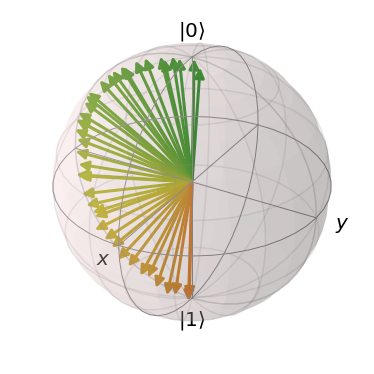

In [7]:
data = """0.0 0.06800000000000006 0.10200000000000009 0.9530000000000001
0.0785398163397 -0.01100000000000001 0.010000000000000009 0.954
0.157079632679 0.02400000000000002 -0.08399999999999996 0.9359999999999999
0.235619449019 0.008999999999999897 -0.14500000000000002 0.9319999999999999
0.314159265359 0.06000000000000005 -0.17900000000000005 0.913
0.392699081699 0.02200000000000002 -0.22699999999999998 0.897
0.471238898038 0.026000000000000023 -0.349 0.8720000000000001
0.549778714378 0.04299999999999993 -0.41300000000000003 0.8380000000000001
0.628318530718 0.09400000000000008 -0.45399999999999996 0.7709999999999999
0.706858347058 0.052999999999999936 -0.512 0.76
0.785398163397 0.05400000000000005 -0.571 0.7050000000000001
0.863937979737 0.052000000000000046 -0.579 0.635
0.942477796077 0.05600000000000005 -0.669 0.605
1.02101761242 0.10200000000000009 -0.685 0.498
1.09955742876 0.09400000000000008 -0.718 0.4670000000000001
1.1780972451 0.028000000000000025 -0.748 0.3640000000000001
1.25663706144 0.05600000000000005 -0.819 0.31200000000000006
1.33517687778 0.05699999999999994 -0.7989999999999999 0.246
1.41371669412 0.026999999999999913 -0.823 0.2270000000000001
1.49225651046 0.04299999999999993 -0.852 0.16799999999999993
1.57079632679 0.0040000000000000036 -0.839 0.07299999999999995
1.64933614313 0.020999999999999908 -0.827 -0.008000000000000007
1.72787595947 0.0040000000000000036 -0.848 -0.10999999999999999
1.80641577581 0.04899999999999993 -0.8220000000000001 -0.15900000000000003
1.88495559215 0.020000000000000018 -0.798 -0.17600000000000005
1.96349540849 0.04800000000000004 -0.776 -0.28800000000000003
2.04203522483 0.04899999999999993 -0.728 -0.353
2.12057504117 0.02299999999999991 -0.71 -0.41600000000000004
2.19911485751 0.02499999999999991 -0.696 -0.44299999999999995
2.27765467385 0.08699999999999997 -0.646 -0.487
2.35619449019 0.06499999999999995 -0.5900000000000001 -0.55
2.43473430653 0.05800000000000005 -0.5529999999999999 -0.608
2.51327412287 0.08600000000000008 -0.469 -0.637
2.59181393921 0.06899999999999995 -0.42500000000000004 -0.7050000000000001
2.67035375555 0.06299999999999994 -0.34299999999999997 -0.754
2.74889357189 0.03200000000000003 -0.30600000000000005 -0.775
2.82743338823 0.07499999999999996 -0.21399999999999997 -0.78
2.90597320457 0.09200000000000008 -0.133 -0.829
2.98451302091 0.05600000000000005 -0.09399999999999997 -0.84
3.06305283725 0.02400000000000002 -0.006000000000000005 -0.839
3.14159265359 0.06400000000000006 0.010000000000000009 -0.857""".split()

b = Bloch()
b.vector_color=colors
xs, zs = [], []
while len(data) > 0:
    data.pop(0)
    x, y, z = float(data.pop(0)), float(data.pop(0)), float(data.pop(0))
    norm = np.sqrt(x**2 + y**2 + z**2)
    x, y, z = x / norm, y / norm, z / norm
    xs.append(x); zs.append(z)
    b.add_vectors([x, y, z])
b.show()

In [130]:
b.save('Figures/drag_trajectory_bloch_sphere.svg')

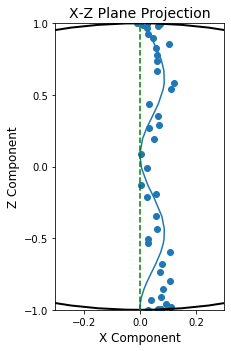

In [20]:
fig, ax = plt.subplots(figsize=(3.5, 5.27))
plt.gcf().subplots_adjust(left=0.23)
plt.scatter(xs, zs)
plt.axis([-0.3, 0.3, -1, 1])
plt.plot(fit_xs, zs)
plt.xlabel('X Component', fontsize=12)
plt.ylabel('Z Component', fontsize=12)
plt.title('X-Z Plane Projection', fontsize=14)
plt.xticks([-0.2, 0, .2])
plt.yticks([-1, -.5, 0, .5, 1])

plt.plot([0, 0], [-1, 1], 'g--')

circle1 = plt.Circle((0, 0), 1, fill=False, linewidth=2)
plt.gcf().gca().add_artist(circle1)


plt.savefig('Figures/drag_trajectory_2d.svg')

In [9]:
from scipy.optimize import curve_fit
fit_func = lambda z, A, w: A * np.sin((-1-z) * w) ** 2

fitparams, conv = curve_fit(fit_func, zs, xs, [0.1, np.pi])
fit_xs = [fit_func(z, *fitparams) for z in zs]